## Importação das Bibliotecas

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.7 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras import regularizers
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import gdown
import plotly.express as px
import plotly.graph_objects as go
from tensorflow.keras import backend as K
from sklearn.cluster import KMeans
from pathlib import Path
# from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.calibration import calibration_curve
# from scikeras.wrappers import KerasClassifier
import optuna
from sklearn.metrics import recall_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.layers import Dropout

In [5]:
## https://drive.google.com/file/d/1foW72R9hTkKPf8z5pf7ZVDg3bQG8tiyi/view?usp=sharing

In [6]:
df_preprocessado = "1foW72R9hTkKPf8z5pf7ZVDg3bQG8tiyi"
url_fraudes = f"https://drive.google.com/uc?id={df_preprocessado}"
gdown.download(url_fraudes, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1foW72R9hTkKPf8z5pf7ZVDg3bQG8tiyi
To: /content/pre_processado_pj.parquet
100%|██████████| 2.01M/2.01M [00:00<00:00, 211MB/s]


'pre_processado_pj.parquet'

In [7]:
pivoted_df = pd.read_parquet('/content/pre_processado_pj.parquet')

## Rodando o modelo de rede neural convolutional LSTM

### Divisão de Treino e Teste

In [8]:
pivoted_df.shape

(42623, 176)

#### Balanceando os dados com Smote (Synthetic Minority Over-sampling Technique)

O smote é uma técnica de "oversampling" usada para balancear datasets com o objetivo de aumentar a quantidade de amostras da classe minoritária gerando novos exemplos sintéticos, em vez de simplesmente replicar os dados existentes. Isso ajuda a melhorar a performance de modelos de machine learning ao treinar com um dataset mais balanceado.

Quando você treina um modelo de machine learning com um dataset desbalanceado (onde uma classe tem muito mais exemplos do que a outra), o modelo tende a favorecer a classe majoritária.

Como resultado, o modelo pode ter um bom desempenho em termos de acurácia geral, mas um desempenho ruim ao identificar a classe minoritária (por exemplo, falhas, fraudes, etc.).

O Smote ajuda a mitigar esse problema ao balancear o dataset, aumentando o número de exemplos da classe minoritária.

In [9]:
# def balanciar(df):
#   smote = SMOTE(random_state=42)
#   X = pivoted_df.drop('DESCRICAO_IRREGULARIDADE IDENTIFICADA', axis=1)
#   y = pivoted_df['DESCRICAO_IRREGULARIDADE IDENTIFICADA']
#   X_res, y_res = smote.fit_resample(X, y)
#   return pd.concat([X_res, y_res], axis=1)

In [10]:
rus = RandomUnderSampler(random_state=42)
X = pivoted_df.drop('DESCRICAO_IRREGULARIDADE IDENTIFICADA', axis=1)
y = pivoted_df['DESCRICAO_IRREGULARIDADE IDENTIFICADA']
X_res, y_res = rus.fit_resample(X, y)

## Testando LSTM - Rodando o modelo

A Long Short-Term Memory (LSTM) é uma arquitetura de rede neural recorrente (RNN) que foi projetada especificamente para aprender dependências de longo prazo em sequências de dados.

Essa capacidade de aprender padrões complexos ao longo do tempo torna as LSTMs particularmente úteis para identificar situações de fraude, onde os padrões fraudulentos podem ser sutis, raros e distribuídos ao longo do tempo.

In [11]:
pivoted_df.columns.values

array(['MATRICULA', 'CONS_MEDIDO_2022-01-01', 'CONS_MEDIDO_2022-02-01',
       'CONS_MEDIDO_2022-03-01', 'CONS_MEDIDO_2022-04-01',
       'CONS_MEDIDO_2022-05-01', 'CONS_MEDIDO_2022-06-01',
       'CONS_MEDIDO_2022-07-01', 'CONS_MEDIDO_2022-08-01',
       'CONS_MEDIDO_2022-09-01', 'CONS_MEDIDO_2022-10-01',
       'CONS_MEDIDO_2022-11-01', 'CONS_MEDIDO_2022-12-01',
       'CONS_MEDIDO_2023-01-01', 'CONS_MEDIDO_2023-02-01',
       'CONS_MEDIDO_2023-03-01', 'CONS_MEDIDO_2023-04-01',
       'CONS_MEDIDO_2023-05-01', 'CONS_MEDIDO_2023-06-01',
       'CONS_MEDIDO_2023-07-01', 'CONS_MEDIDO_2023-08-01',
       'CONS_MEDIDO_2023-09-01', 'CONS_MEDIDO_2023-10-01',
       'CONS_MEDIDO_2023-11-01', 'CONS_MEDIDO_2023-12-01',
       'CONS_MEDIDO_2024-01-01', 'Precipitação_2022-01-01',
       'Precipitação_2022-02-01', 'Precipitação_2022-03-01',
       'Precipitação_2022-04-01', 'Precipitação_2022-05-01',
       'Precipitação_2022-06-01', 'Precipitação_2022-07-01',
       'Precipitação_2022-08-01', 'P

Conversando com o orientador César, optamos por seguir com a proposta de dividir os dados categóricos dos númericos, visto que a LSTM poderia interpretar os valores categóricos como parte ou sequência dos numéricos

In [12]:
X_numeric_seq = pivoted_df.drop(['MATRICULA', 'DESCRICAO_IRREGULARIDADE IDENTIFICADA'] + list(pivoted_df.filter(regex='^ECO_[CIP]|^cluster_').columns), axis=1).values
X_categorical_seq = pivoted_df[['TIPO_LIGACAO_Consumo Fixo', 'TIPO_LIGACAO_Hidrometrado', 'DSC_OCORRENCIA_MEDIDOR NÃO LOCALIZADO', 'DSC_OCORRENCIA_MEDIDOR RETIRADO/FURTADO', 'DSC_OCORRENCIA_NORMAL'] + list(pivoted_df.filter(regex='^ECO_[CIP]|^cluster_').columns)].values

# X_numeric_seq = pivoted_df.drop(['MATRICULA','DESCRICAO_IRREGULARIDADE IDENTIFICADA', 'TIPO_LIGACAO_Consumo Fixo', 'TIPO_LIGACAO_Hidrometrado',
#        'DSC_OCORRENCIA_MEDIDOR NÃO LOCALIZADO',
#        'DSC_OCORRENCIA_MEDIDOR RETIRADO/FURTADO', 'DSC_OCORRENCIA_NORMAL','ECO_COMERCIAL_2.0',
#        'ECO_COMERCIAL_3.0', 'ECO_COMERCIAL_4.0', 'ECO_COMERCIAL_5.0',
#        'ECO_COMERCIAL_6.0', 'ECO_COMERCIAL_7.0', 'ECO_COMERCIAL_8.0',
#        'ECO_COMERCIAL_9.0', 'ECO_COMERCIAL_10.0', 'ECO_COMERCIAL_11.0',
#        'ECO_COMERCIAL_12.0', 'ECO_COMERCIAL_13.0', 'ECO_COMERCIAL_14.0',
#        'ECO_COMERCIAL_15.0', 'ECO_COMERCIAL_16.0', 'ECO_COMERCIAL_17.0',
#        'ECO_COMERCIAL_18.0', 'ECO_COMERCIAL_21.0', 'ECO_COMERCIAL_22.0',
#        'ECO_COMERCIAL_23.0', 'ECO_COMERCIAL_24.0', 'ECO_COMERCIAL_27.0',
#        'ECO_COMERCIAL_29.0', 'ECO_COMERCIAL_33.0', 'ECO_COMERCIAL_36.0',
#        'ECO_COMERCIAL_40.0', 'ECO_COMERCIAL_47.0', 'ECO_COMERCIAL_48.0',
#        'ECO_COMERCIAL_51.0', 'ECO_COMERCIAL_54.0', 'ECO_COMERCIAL_61.0',
#        'ECO_COMERCIAL_62.0', 'ECO_COMERCIAL_70.0', 'ECO_COMERCIAL_80.0',
#        'ECO_COMERCIAL_91.0', 'ECO_COMERCIAL_98.0', 'ECO_COMERCIAL_101.0',
#        'ECO_COMERCIAL_124.0', 'ECO_COMERCIAL_149.0',
#        'ECO_COMERCIAL_175.0', 'ECO_COMERCIAL_363.0', 'ECO_INDUSTRIAL_0.0',
#        'ECO_INDUSTRIAL_1.0', 'ECO_INDUSTRIAL_2.0', 'ECO_INDUSTRIAL_10.0',
#        'ECO_PUBLICA_0.0', 'ECO_PUBLICA_1.0',
#        'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
#        'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9',
#        'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13',
#        'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17',
#        'cluster_18', 'cluster_19'], axis=1).values
# X_categorical_seq = pivoted_df[['TIPO_LIGACAO_Consumo Fixo', 'TIPO_LIGACAO_Hidrometrado',
#        'DSC_OCORRENCIA_MEDIDOR NÃO LOCALIZADO',
#        'DSC_OCORRENCIA_MEDIDOR RETIRADO/FURTADO', 'DSC_OCORRENCIA_NORMAL', 'ECO_COMERCIAL_2.0',
#        'ECO_COMERCIAL_3.0', 'ECO_COMERCIAL_4.0', 'ECO_COMERCIAL_5.0',
#        'ECO_COMERCIAL_6.0', 'ECO_COMERCIAL_7.0', 'ECO_COMERCIAL_8.0',
#        'ECO_COMERCIAL_9.0', 'ECO_COMERCIAL_10.0', 'ECO_COMERCIAL_11.0',
#        'ECO_COMERCIAL_12.0', 'ECO_COMERCIAL_13.0', 'ECO_COMERCIAL_14.0',
#        'ECO_COMERCIAL_15.0', 'ECO_COMERCIAL_16.0', 'ECO_COMERCIAL_17.0',
#        'ECO_COMERCIAL_18.0', 'ECO_COMERCIAL_21.0', 'ECO_COMERCIAL_22.0',
#        'ECO_COMERCIAL_23.0', 'ECO_COMERCIAL_24.0', 'ECO_COMERCIAL_27.0',
#        'ECO_COMERCIAL_29.0', 'ECO_COMERCIAL_33.0', 'ECO_COMERCIAL_36.0',
#        'ECO_COMERCIAL_40.0', 'ECO_COMERCIAL_47.0', 'ECO_COMERCIAL_48.0',
#        'ECO_COMERCIAL_51.0', 'ECO_COMERCIAL_54.0', 'ECO_COMERCIAL_61.0',
#        'ECO_COMERCIAL_62.0', 'ECO_COMERCIAL_70.0', 'ECO_COMERCIAL_80.0',
#        'ECO_COMERCIAL_91.0', 'ECO_COMERCIAL_98.0', 'ECO_COMERCIAL_101.0',
#        'ECO_COMERCIAL_124.0', 'ECO_COMERCIAL_149.0',
#        'ECO_COMERCIAL_175.0', 'ECO_COMERCIAL_363.0', 'ECO_INDUSTRIAL_0.0',
#        'ECO_INDUSTRIAL_1.0', 'ECO_INDUSTRIAL_2.0', 'ECO_INDUSTRIAL_10.0',
#        'ECO_PUBLICA_0.0', 'ECO_PUBLICA_1.0',
#        'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
#        'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9',
#        'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13',
#        'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17',
#        'cluster_18', 'cluster_19']].values
y_seq = pivoted_df['DESCRICAO_IRREGULARIDADE IDENTIFICADA'].values

In [13]:
y_seq.shape

(42623,)

In [14]:
X_combined = np.concatenate((X_numeric_seq, X_categorical_seq), axis=1)

smote = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_combined, y_seq)

# If you want to split the resampled data back into numeric and categorical parts
X_numeric_resampled = X_resampled[:, :X_numeric_seq.shape[1]]
X_categorical_resampled = X_resampled[:, X_numeric_seq.shape[1]:]

In [15]:
np.argmax(X_categorical_seq[:,-20:])

15

In [16]:
#stratify=
#Lembrar de adicionar stratify

In [17]:
# Divisão de dados em treino e teste
X_train_num, X_test_num, X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_numeric_resampled, X_categorical_resampled, y_resampled, test_size=0.2, random_state=42)

# Definindo a entrada da sequência numérica
numeric_input = Input(shape=(X_numeric_seq.shape[1], 1), name='numeric_input')

# Camada LSTM para variáveis numéricas
x_numeric = LSTM(64, return_sequences=False)(numeric_input) #kernel_regularizer=regularizers.l2(0.01)
x_numeric = Dropout(0.05)(x_numeric)

# Definindo a entrada da sequência categórica
categorical_input = Input(shape=(X_categorical_seq.shape[1],), name='categorical_input')

# Camada Densa para variáveis categóricas
x_categorical = Dense(32, activation='relu')(categorical_input) #kernel_regularizer=regularizers.l2(0.01)
x_categorical = Dropout(0.05)(x_categorical)

# Concatenando as saídas das camadas numéricas e categóricas
concatenated = Concatenate()([x_numeric, x_categorical])

# Camada Densa final
output = Dense(1, activation='sigmoid')(concatenated)

# Criando o modelo
model_lstm = Model(inputs=[numeric_input, categorical_input], outputs=output)

# Compilando o modelo
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

# Reshape necessário para a entrada numérica
X_train_num = np.expand_dims(X_train_num, axis=-1)
X_test_num = np.expand_dims(X_test_num, axis=-1)

# Treinamento do modelo
hisotry = model_lstm.fit([X_train_num, X_train_cat], y_train, epochs=50, batch_size=81, validation_split=0.2)

# Avaliação do modelo
# Avaliação do modelo
loss, accuracy, precision, recall = model_lstm.evaluate([X_test_num, X_test_cat], y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Model Accuracy: {accuracy:.2f}')
print(f'Model Precision: {precision:.2f}')
print(f'Model Recall: {recall:.2f}')

Epoch 1/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5718 - loss: 0.6728 - precision: 0.5881 - recall: 0.5030 - val_accuracy: 0.6191 - val_loss: 0.6525 - val_precision: 0.5986 - val_recall: 0.6852
Epoch 2/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6291 - loss: 0.6405 - precision: 0.6394 - recall: 0.5839 - val_accuracy: 0.6571 - val_loss: 0.6303 - val_precision: 0.6598 - val_recall: 0.6256
Epoch 3/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6631 - loss: 0.6097 - precision: 0.6853 - recall: 0.6041 - val_accuracy: 0.6963 - val_loss: 0.5854 - val_precision: 0.7294 - val_recall: 0.6083
Epoch 4/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6933 - loss: 0.5805 - precision: 0.7426 - recall: 0.5961 - val_accuracy: 0.7134 - val_loss: 0.5673 - val_precision: 0.7651 - val_recall: 0.6023
Epoch 5/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7050 - loss: 0.5632 - precision: 0.7617 - recall: 0.5912 - val_accuracy: 0.7115 - val_loss: 0

In [18]:
matriz = pd.DataFrame(data={'cluster': np.argmax(X_test_cat[:,-20:], axis=1),
                   'real': y_test,
                   'prev': np.argmax(model_lstm.predict([X_test_num,X_test_cat]), axis=1)})

424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [19]:
matriz['acc'] = matriz.real == matriz.prev

In [20]:
matriz

,cluster,real,prev,acc
0,13,0.0,0,True
1,0,0.0,0,True
2,10,0.0,0,True
3,19,1.0,0,False
4,5,1.0,0,False
...,...,...,...,...
13554,5,0.0,0,True
13555,17,0.0,0,True
13556,17,0.0,0,True
13557,2,1.0,0,False


In [21]:
matriz[matriz['cluster']==0]

,cluster,real,prev,acc
1,0,0.0,0,True
7,0,1.0,0,False
72,0,0.0,0,True
96,0,1.0,0,False
118,0,1.0,0,False
...,...,...,...,...
13443,0,0.0,0,True
13449,0,0.0,0,True
13517,0,0.0,0,True
13524,0,0.0,0,True


In [22]:
matriz[matriz['cluster']==0].pivot_table(index='real', columns='prev', values='acc', aggfunc='count')

prev,0
real,
0.0,277
1.0,319


In [23]:
acuracia_por_cluster = matriz.pivot_table(index='cluster', values='acc', aggfunc=['sum','count'])

In [24]:
acuracia_por_cluster['acuracia'] = acuracia_por_cluster[('sum', 'acc')]/acuracia_por_cluster[('count', 'acc')]

In [25]:
acuracia_por_cluster

,sum,count,acuracia
,acc,acc,
cluster,,,
0,277,596,0.464765
1,428,930,0.460215
2,324,695,0.466187
3,412,680,0.605882
4,17,26,0.653846
5,215,473,0.454545
6,287,602,0.476744
7,850,1663,0.511124


## Salvando o Modelo utilizando Pickle

In [26]:
import pickle

with open("modelo_lstm_PJ.pkl", "wb") as file:
    pickle.dump(model_lstm, file)

### Hiperparâmetros

In [27]:
# def objective(trial):
#     # Definindo os hiperparâmetros para otimização
#     n_lstm_units = trial.suggest_int('n_lstm_units', 32, 128)
#     n_dense_units = trial.suggest_int('n_dense_units', 16, 64)
#     dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.75)
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
#     batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
#     epochs = trial.suggest_int('epochs', 10, 100)

#     # Definindo a entrada da sequência numérica
#     numeric_input = Input(shape=(X_numeric_seq.shape[1], 1), name='numeric_input')
#     x_numeric = LSTM(n_lstm_units, return_sequences=False, dropout=dropout_rate)(numeric_input)

#     # Definindo a entrada da sequência categórica
#     categorical_input = Input(shape=(X_categorical_seq.shape[1],), name='categorical_input')
#     x_categorical = Dense(n_dense_units, activation='relu')(categorical_input)

#     # Concatenando as saídas das camadas numéricas e categóricas
#     concatenated = Concatenate()([x_numeric, x_categorical])
#     output = Dense(1, activation='sigmoid')(concatenated)

#     # Criando o modelo
#     model_lstm = Model(inputs=[numeric_input, categorical_input], outputs=output)

#     # Compilando o modelo
#     model_lstm.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

#     # Reshape necessário para a entrada numérica
#     X_numeric_train_reshaped = np.expand_dims(X_train_num, axis=-1)
#     X_numeric_test_reshaped = np.expand_dims(X_test_num, axis=-1)

#     # Treinamento do modelo
#     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#     # Predição e cálculo do recall
#     y_pred = model_lstm.predict([X_numeric_test_reshaped, X_test_cat])
#     y_pred_classes = (y_pred > 0.5).astype(int)
#     recall = recall_score(y_test, y_pred_classes)

#     # Limpando sessão do Keras para evitar sobrecarga de memória
#     K.clear_session()

#     return recall

# # Rodando a otimização
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=25)

# # Melhor conjunto de hiperparâmetros
# print("Melhores hiperparâmetros:", study.best_params)
# print("Melhor recall alcançado:", study.best_value)

## Métricas

424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      6775
         1.0       0.82      0.71      0.76      6784

    accuracy                           0.78     13559
   macro avg       0.78      0.78      0.78     13559
weighted avg       0.78      0.78      0.78     13559

Confusion Matrix:
 [[5756 1019]
 [1990 4794]]


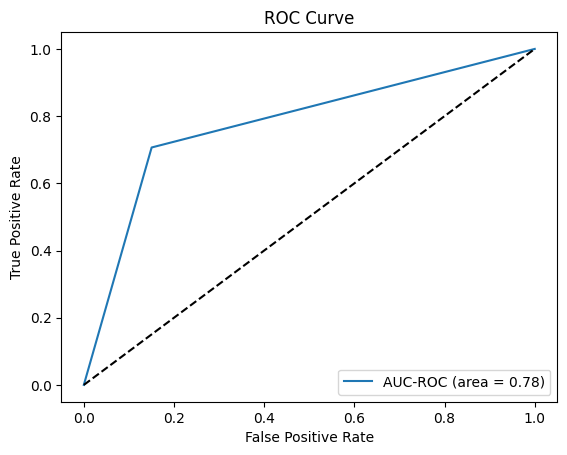

In [28]:
# y_pred = (model_lstm.predict(x_numeric) > 0.5).astype("int32")

X_numeric_train_reshaped = np.expand_dims(X_train_num, axis=-1)
X_numeric_test_reshaped = np.expand_dims(X_test_num, axis=-1)

X_numeric_train_reshaped = np.squeeze(X_numeric_train_reshaped, axis=2) # Removing the extra dimension (axis=2)
X_numeric_test_reshaped = np.squeeze(X_numeric_test_reshaped, axis=2) # Removing the extra dimension (axis=2

y_pred = model_lstm.predict([X_numeric_test_reshaped, X_test_cat])
y_pred_classes = (y_pred > 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred_classes))

conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)


# y_pred_prob = model_lstm.predict([X_test_cat]).ravel()
roc_auc = roc_auc_score(y_test, y_pred_classes)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_classes)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC-ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Acurácia (Accuracy): 72% indica que o modelo classifica corretamente cerca de 72% dos casos no conjunto de teste. Isso é uma medida geral do desempenho, mas pode mascarar problemas em classes desbalanceadas.

Precisão (Precision): Para a classe 1, a precisão de 0.79 indica que 79% das previsões positivas foram corretas, ou seja, das previsões classificadas como fraude, 79% eram fraudes de fato. Isso é importante em um cenário de detecção de fraudes, onde falsos positivos podem gerar custos.

Recall: A taxa de recall de 0.59 para a classe 1 mostra que o modelo recupera apenas 59% das fraudes reais. Ou seja, ele falha em detectar uma fração significativa das fraudes, o que pode ser uma limitação importante, dependendo da aplicação.

F1-Score: O F1 de 0.68 para a classe 1 reflete o equilíbrio entre precisão e recall. Nesse caso, o modelo está mais focado em reduzir falsos positivos (alta precisão), mas compromete a taxa de detecção (recall).

AUC-ROC: Com uma AUC de 0.72, o modelo está razoavelmente bem em termos de distinção entre fraudes e não fraudes. Uma AUC maior que 0.7 indica um bom nível de separabilidade, embora haja espaço para melhoria.

Text(50.722222222222214, 0.5, 'Valor Real')

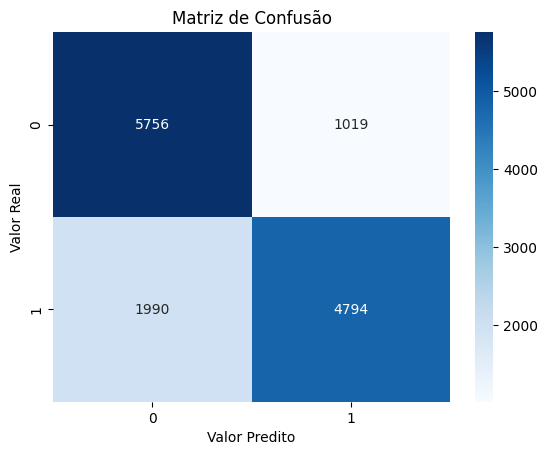

In [29]:
import seaborn as sns

# Primeiro você deve calcular VP, VN, FP e FN de acordo com os targets reais
# (y_real) e os targets previstos (y_pred) pelo seu modelo

matriz_conf = confusion_matrix(y_test, y_pred_classes)

# Em seguida você pode plotá-los na forma de matriz de confusão que conhecemos
sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues')

# E aqui indicar algumas informações como título, eixo X e eixo Y
plt.title('Matriz de Confusão')
plt.xlabel('Valor Predito')
plt.ylabel('Valor Real')

Falsos Positivos (FP): O modelo cometeu 1004 erros ao classificar registros como fraudes quando, na verdade, não eram (linha 0, coluna 1). Dependendo do custo de um falso positivo, isso pode ser aceitável ou não.

Falsos Negativos (FN): O modelo falhou em detectar 2665 fraudes (linha 1, coluna 0). Este é um problema mais crítico, pois fraudes não detectadas podem resultar em perdas diretas.

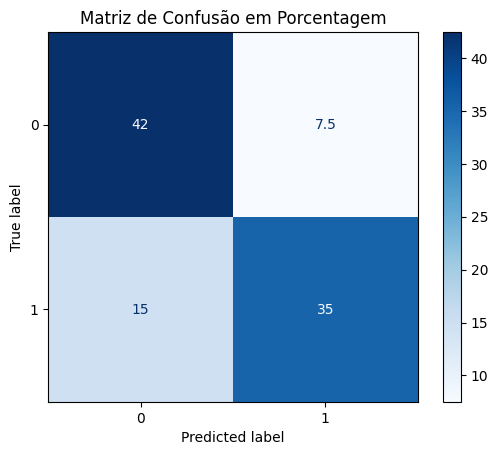

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
#Calculando a matriz de confusão em porcentagem
cm_percentage = matriz_conf.astype('float') / matriz_conf.sum() * 100

# Exibindo a matriz de confusão com porcentagens
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)

plt.title('Matriz de Confusão em Porcentagem')
plt.show()

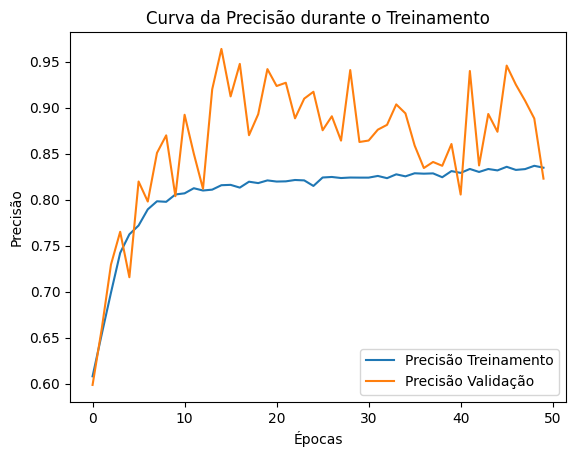

In [31]:
import matplotlib.pyplot as plt

# Plotando a curva de aprendizado
plt.plot(hisotry.history['precision'], label='Precisão Treinamento')
plt.plot(hisotry.history['val_precision'], label='Precisão Validação')
plt.title('Curva da Precisão durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()
plt.show()

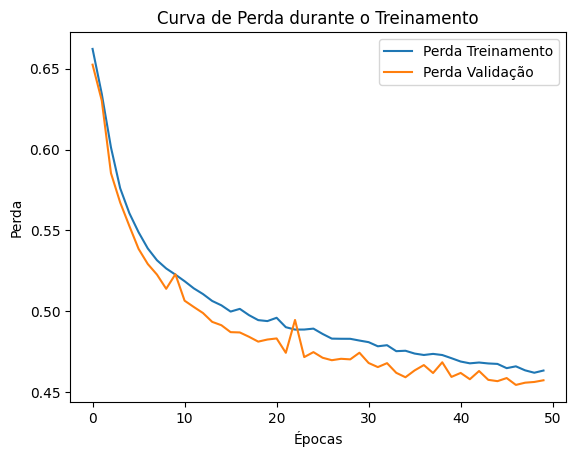

In [32]:
plt.plot(hisotry.history['loss'], label='Perda Treinamento')
plt.plot(hisotry.history['val_loss'], label='Perda Validação')
plt.title('Curva de Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


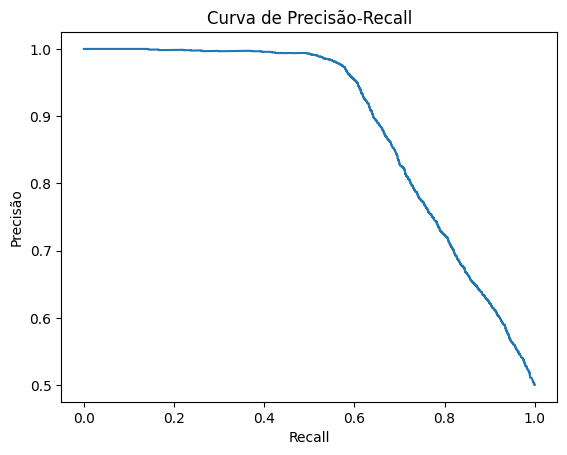

In [33]:
from sklearn.metrics import precision_recall_curve

X_test_num = np.asarray(X_test_num).astype('float32')
X_test_cat = np.asarray(X_test_cat).astype('float32')

y_pred_prob = model_lstm.predict([X_test_num, X_test_cat])

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.plot(recall, precision)
plt.title('Curva de Precisão-Recall')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.show()

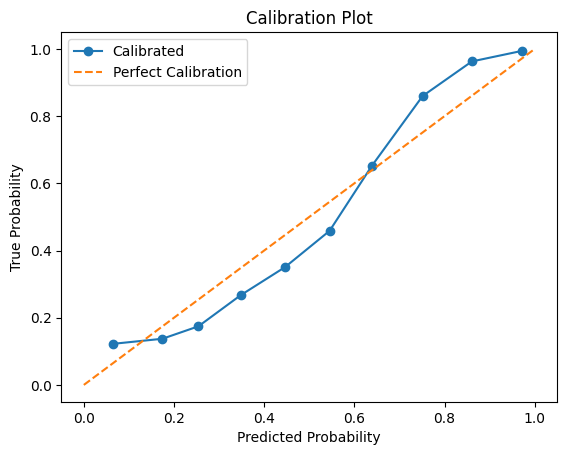

In [34]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Plot')
plt.legend()
plt.show()

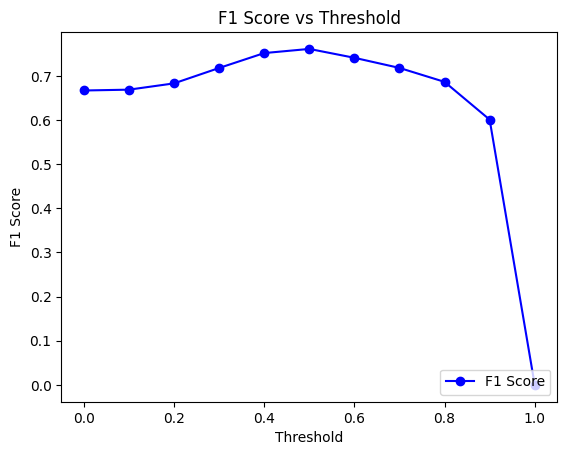

In [35]:
from sklearn.metrics import f1_score

thresholds = np.arange(0, 1.1, 0.1)
f1_scores = [f1_score(y_test, (y_pred_prob >= t).astype(int)) for t in thresholds]

plt.figure()
plt.plot(thresholds, f1_scores, marker='o', color='b', label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend(loc='lower right')
plt.show()

## F1 vs Limiar de decisão

O F1 Score equilibra precisão e recall, e a variação em relação ao threshold de decisão mostra o comportamento do modelo ao classificar exemplos. O gráfico indica que o F1 Score aumenta e atinge seu pico em torno de um threshold entre 0.3 e 0.4. Esse valor sugere que, nesse intervalo de threshold, o modelo PJ está conseguindo o melhor equilíbrio entre precisão e recall. A partir de 0.4, o F1 Score começa a cair gradualmente e apresenta uma queda acentuada em torno de 1.0, indicando que o modelo se torna mais conservador e classifica menos exemplos como positivos, o que prejudica o recall e consequentemente o F1 Score.

Ponto de Otimização: O threshold de 0.3-0.4 é o ideal para maximizar o F1 Score no modelo PJ. Ajustar o threshold para este intervalo pode melhorar o desempenho geral.

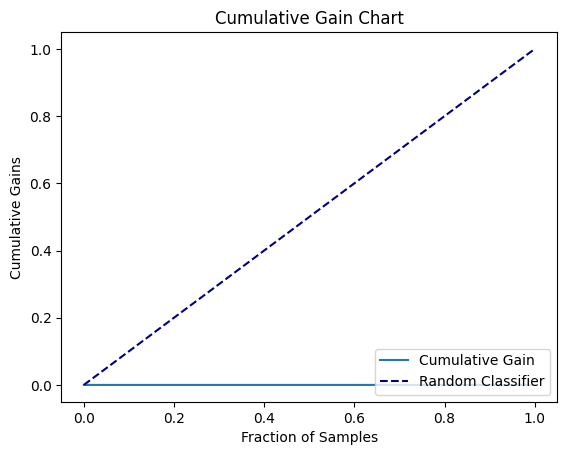

In [36]:
sorted_pred_probs = np.sort(y_pred_prob)[::-1]
sorted_true_labels = y_test[np.argsort(y_pred_prob)[::-1]]

cumulative_gains = np.cumsum(sorted_true_labels)
total_positives = np.sum(y_test)
cumulative_gains = cumulative_gains / total_positives

plt.plot(np.arange(1, len(y_test) + 1) / len(y_test), cumulative_gains, label='Cumulative Gain')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier')
plt.xlabel('Fraction of Samples')
plt.ylabel('Cumulative Gains')
plt.title('Cumulative Gain Chart')
plt.legend(loc='lower right')
plt.show()

## Cumulative Gain

O gráfico de ganho cumulativo compara o desempenho do modelo em relação a um classificador aleatório. Como o ganho cumulativo do modelo PJ está muito próximo de zero e abaixo da linha de referência (classificador aleatório), isso indica que o modelo não está fornecendo uma classificação efetiva e não está conseguindo capturar os exemplos positivos com eficiência. Esse resultado pode sugerir que o modelo está subajustado ou que precisa de uma recalibração para aumentar a capacidade de discriminar entre as classes.

A análise deste gráfico indica que o modelo PJ provavelmente precisa de melhorias significativas na sua capacidade de identificar corretamente exemplos positivos. Pode ser interessante revisar a qualidade dos dados de treinamento ou os parâmetros do modelo para melhorar o ganho cumulativo.

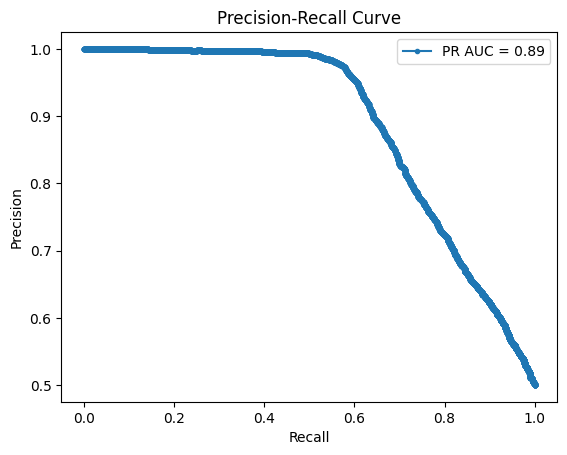

In [37]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

### Precisão - Recall

A curva de precisão e recall mostra a relação entre essas duas métricas à medida que o threshold de decisão varia. O valor da AUC da Precision-Recall Curve é 0.83, indicando que o modelo possui uma boa capacidade de manter uma alta precisão enquanto tenta aumentar o recall. No entanto, podemos observar que, ao tentar aumentar o recall (indo para a direita no eixo x), a precisão começa a cair drasticamente. Isso sugere que, à medida que o modelo tenta capturar mais exemplos positivos (aumentar o recall), ele comete mais erros de classificação, reduzindo a precisão.

Conclusão: Um AUC de 0.83 é um bom valor, indicando que o modelo PJ está conseguindo um bom equilíbrio entre precisão e recall, mas há uma troca clara quando se tenta aumentar o recall, pois a precisão cai. O modelo parece ter um desempenho aceitável, mas há espaço para melhorias no balanceamento entre as duas métricas.